# Homework 07

## Group 10

This week we are going to build an autoencoder. In fact we are building two autoencoders. First a simple convolutional one and then a variational autoencoder. The dataset we are going to use is the [fashion mnist dataset](https://keras.io/api/datasets/fashion_mnist/) which we can conviniently import from keras. So let's get started, import it and take a look at what we are dealing with this week.

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

Now that our data is loaded, take a look at the formatting and general structure

In [6]:
print(f"Train image shape: {train_images.shape} \nTest image shape: {test_images.shape}")

Train image shape: (60000, 28, 28) 
Test image shape: (10000, 28, 28)


So there are 60000 training images with a size of 28x28 pixels, as well as 10000 test images with the same dimension. Let's plot some examples. For since the labels are only numbers again, we are going to apply the same technique as in the last couple of weeks by using a helper function to match the number to the corresponding word label. Also notice that our images are only grayscale this week and not RGB colored as the CIFAR dataset. So we have to pass a colormap (cmap) to matplotlib otherwise it will use its default color scheme for the images. 

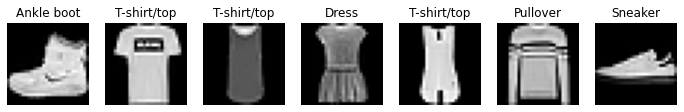

In [8]:
def class_names(label):
    """Little helper function to map a label to the corresponding word"""
    label_words = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    return label_words[int(label)]

fig, ax = plt.subplots(1, 7, figsize=(12,6))

for i in range(len(ax)):

    ax[i].imshow(train_images[i], cmap="gray")
    ax[i].set_title(class_names(train_labels[i]))
    ax[i].axis("off")

# Building the input pipeline

Since the autoencoders will not use the labels we can disregard them.

In [10]:
# Input Pipeline

# Hyperparameters
batch_size = 64
prefetch_size = tf.data.experimental.AUTOTUNE

# tf.data.Dataset.from_tensor_slices creates a tf.dataset from a tensor. The elements of the dataset are slices of the first tensor dimension
train_dataset= tf.data.Dataset.from_tensor_slices(train_images)

#we normalize our data and center the pixel values around zero
train_dataset = train_dataset.map(lambda img : (tf.cast(img/255, tf.float32)))
train_dataset = train_dataset.map(lambda img : tf.reshape(img, (28,28,1)))
train_dataset = train_dataset.shuffle(buffer_size=128)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(prefetch_size)

# repeat for the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset = test_dataset.map(lambda img : (tf.cast(img/255, tf.float32)))
test_dataset = test_dataset.map(lambda img : tf.reshape(img, (28,28,1)))
test_dataset = test_dataset.shuffle(buffer_size=128)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(prefetch_size)


# Model

## Convolutional Autoencoder

Rough version:
Create Encoder and Decoder as Subclasses
Choice of activation functions is based on tensorflow tutorial, but would be nice to have graphs of the functions to explain why we chose them. For the number of neurons in the Decoder 28x28=784 is chosen. Might make sense to set this dynamically or at least explain why. The model setup is based on [the tensorflow autoencoder tutorial](https://www.tensorflow.org/tutorials/generative/autoencoder). 


In [30]:
# Convolutional Autoencoder
from tensorflow.keras import layers


class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.layer_list = [
            layers.Conv2D(2,3,strides=2),
            layers.Conv2D(2,3,strides=2),
            layers.Flatten(),
            layers.Dense(latent_dim, activation="relu")
        ]
    
    def call(self, x):
        for layer in self.layer_list:
            x = layer(x)
        return x
        

class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer_list = [
            layers.Dense(784, activation="sigmoid"),
            layers.Reshape((28, 28, 1)),
            layers.Conv2DTranspose(1, 14),
            layers.Conv2DTranspose(1, 15),
            layers.Conv2D(1, 28, activation="sigmoid")
        ]

    def call(self, x):
        for layer in self.layer_list:
            x = layer(x)
        return x


class ConvolutionalAutoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(ConvolutionalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder()

    def call(self, x, training=False):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Variational Autoencoder

In [14]:
# Variational Autoencoder

# Training

In [16]:
# New Visualization Function
def plot_autoencoder(original, reconstruction):
    pass


In [22]:
def train_step(model, input, original, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input, training=True)
    loss = loss_function(original, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 


def test(model, test_data):
  # test over complete test data
  originals = []
  reconstructions = []

  for input in test_data:
    originals.append(input)
    reconstructions.append(model(input))  
  return originals, reconstructions


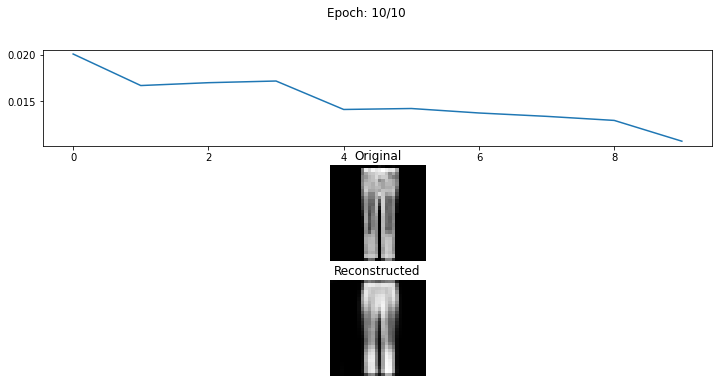

In [32]:
import time
from IPython.display import clear_output
%matplotlib inline
tf.keras.backend.clear_session()

model = ConvolutionalAutoencoder(64) # I have no idea why 64 yet - maybe batch size?
num_epochs = 10
learning_rate = 0.001
train_losses = []
test_losses = []
loss_function = tf.losses.MeanSquaredError()
optimizer = tf.optimizers.Adam(learning_rate)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    start = time.perf_counter()
    
    #training (and checking in with training)
    for input in train_dataset:
        train_loss = train_step(model, input, input, loss_function, optimizer)
    train_losses.append(train_loss)

    #train_dataset = train_dataset.shuffle(buffer_size=128)

    end = time.perf_counter()
    original_img, reconstructed_img = test(model, test_dataset)


    # Plotting
    clear_output(wait=True) # Clear the previous graph
    fig, ax = plt.subplots(3,1, figsize=(12,6))
    fig.suptitle(f"Epoch: {epoch+1}/{num_epochs}")
    ax[0].plot(train_losses)
    ax[1].imshow(original_img[0].numpy()[0], cmap="gray")
    ax[2].imshow(reconstructed_img[0].numpy()[0], cmap="gray")
    ax[1].set_title("Original")
    ax[2].set_title("Reconstructed")
    ax[1].axis("off")
    ax[2].axis("off")
    plt.show()


TODO:
- ~~Inline plotting of original images with reconstructions while training (tf.summary might be an idea for that)~~
- Code cleanup and comments
- Variational Autoencoder
- Training loop as a function